In [2]:
import pandas as pd
import json
import requests
from pymongo import MongoClient
from bson.objectid import ObjectId
import os
from pprint import pprint

In [8]:
with open('D:\\lianz\\Desktop\\Python\\personal_projects\\finance_dashboard\\mongodb_api.txt','r') as f:
    cluster = f.readlines()[0]
    
client = MongoClient(cluster)

# print(client.list_database_names())

db = client.FinanceApp
balance_sheet_collection = db.balance_sheet
income_collection = db.income_statement
cash_collection = db.cash_flow_statement
company_profile = db.company_profile
historical = db.historical

In [46]:
arr = os.listdir(r"D:\\lianz\Desktop\\Python\\personal_projects\\personal_finance\\balance-sheet-statement")
len(arr)

69

In [7]:
with open('D:\\lianz\\Desktop\\Python\\personal_projects\\finance_dashboard\\fmp_api.txt','r') as f:
    fmp_api = f.readlines()[0]

In [130]:
def select_profile(ticker, statement):
    r = requests.get(
        f"https://financialmodelingprep.com/api/v3/{statement}/{ticker}?apikey={fmp_api}")
    r = r.json()
    return r

In [131]:
a_profile = select_profile('A','profile')

In [141]:
a_profile[0]['symbol']

'A'

In [ ]:
company_profile.insert_one(a_profile[0])

In [9]:
from pymongo import ASCENDING, DESCENDING

In [229]:
a_data = [i for i in balance_sheet_collection.find({'symbol':'AAL'}).sort('date', DESCENDING)]

In [227]:
a_data

[{'_id': ObjectId('63e01eb2834e96fbdea52b13'),
  'date': '2021-12-31',
  'symbol': 'AAL',
  'reportedCurrency': 'USD',
  'cik': '0000006201',
  'fillingDate': '2022-02-22',
  'acceptedDate': '2022-02-22 08:03:11',
  'calendarYear': '2021',
  'period': 'FY',
  'cashAndCashEquivalents': 273000000,
  'shortTermInvestments': 12158000000,
  'cashAndShortTermInvestments': 12431000000,
  'netReceivables': 1505000000,
  'inventory': 1795000000,
  'otherCurrentAssets': 1605000000,
  'totalCurrentAssets': 17336000000,
  'propertyPlantEquipmentNet': 37387000000,
  'goodwill': 4091000000,
  'intangibleAssets': 1988000000,
  'goodwillAndIntangibleAssets': 6079000000,
  'longTermInvestments': 0,
  'taxAssets': 3556000000,
  'otherNonCurrentAssets': 2109000000,
  'totalNonCurrentAssets': 49131000000,
  'otherAssets': 0,
  'totalAssets': 66467000000,
  'accountPayables': 1772000000,
  'shortTermDebt': 3996000000,
  'taxPayables': 0,
  'deferredRevenue': 8983000000,
  'otherCurrentLiabilities': 4255000

In [156]:
company_profile.delete_one({})

##### Define function to access elements of an entry in database
Use function to access individual elements of a document in a collection

In [10]:
def access_entry(collection_name, entry_name, entry_value, return_value):
    data = collection_name.find({entry_name:entry_value})

    data = [i[return_value] for i in data]

    return data

##### Get list of tickers in database

In [208]:
balance_list = list(set([i['symbol'] for i in balance_sheet_collection.find()]))
income_list = list(set([i['symbol'] for i in income_collection.find()]))
cash_list = list(set([i['symbol'] for i in cash_collection.find()]))
company_list = list(set([i['symbol'] for i in company_profile.find()]))
list_tickers = [balance_list, income_list, cash_list, company_list]
lengths = [len(i) for i in list_tickers]
missing_tickers = [i for i in list_tickers if len(i) == max(lengths)]

In [163]:
profiles = [select_profile(i,'profile') for i in balance_list]

In [210]:
downloaded = [i[0]['symbol'] for i in profiles if len(i)>0]

[]

In [53]:
def select_quote(ticker, statement):
    r = requests.get(
        f"https://financialmodelingprep.com/api/v3/{statement}/{ticker}?limit=120&apikey=eb29218df82acef0486b5c014ccec868")
    r = r.json()
    return r

##### Insert to database from API

In [109]:
def insert_to_mongoDB(ticker):

    balance = select_quote(ticker, 'balance-sheet-statement')
    income = select_quote(ticker, 'income-statement')
    cash_flow = select_quote(ticker, 'cash-flow-statement')

    if len(balance) <= 1 or len(income) <= 1 or len(cash_flow) <= 1:
        pass
    else:
        for i in balance:
            i['index_id'] = f"{i['symbol']}_{i['date']}"
        for i in income:
            i['index_id'] = f"{i['symbol']}_{i['date']}"    
        for i in cash_flow:
            i['index_id'] = f"{i['symbol']}_{i['date']}"
        
        bal_ids = [i['index_id'] for i in balance if i['index_id'] not in access_entry(balance_sheet_collection,'symbol',i['symbol'],'index_id')]
        income_ids = [i['index_id'] for i in income if i['index_id'] not in access_entry(income_collection,'symbol',i['symbol'],'index_id')]
        cash_ids = [i['index_id'] for i in cash_flow if i['index_id'] not in access_entry(cash_collection,'symbol',i['symbol'],'index_id')]

        try:
            balance_sheet_collection.insert_many([i for i in balance if i['index_id'] in bal_ids])
            income_collection.insert_many([i for i in income if i['index_id'] in income_ids])
            cash_collection.insert_many([i for i in cash_flow if i['index_id'] in cash_ids])
        except:
            pass

##### Insert to database from API per collection

In [117]:
def insert_to_mongoDB(collection, ticker, statement):

    statement = select_quote(ticker, statement)

    if len(statement) <= 1:
        pass
    else:
        for i in statement:
            i['index_id'] = f"{i['symbol']}_{i['date']}"
        
        ids = [i['index_id'] for i in statement if i['index_id'] not in access_entry(collection,'symbol',i['symbol'],'index_id')]

        try:
            collection.insert_many([i for i in statement if i['index_id'] in ids])
        except:
            print('statement already exists.')

In [122]:
insert_to_mongoDB(balance_sheet_collection, 'AAL', 'balance-sheet-statement')
insert_to_mongoDB(cash_collection, 'AAL', 'cash-flow-statement')
insert_to_mongoDB(income_collection, 'AAL', 'income-statement')

statement already exists.
statement already exists.
statement already exists.


In [22]:
# balance_sheet_collection.create_index('index_id', unique=True)
# cash_collection.create_index('index_id', unique=True)
# income_collection.create_index('index_id', unique=True)
# company_profile.create_index('index_id', unique=True)
historical.create_index('index_id', unique=True)

'index_id_1'

##### Insert to database from local computer

In [8]:
def insert_to_mongoDB(ticker):

    balance = f'D:\\lianz\\Desktop\\Python\\personal_projects\\personal_finance\\balance-sheet-statement\\{ticker}'
    income = f'D:\\lianz\\Desktop\\Python\\personal_projects\\personal_finance\\income-statement\\{ticker}'
    cash_flow = f'D:\\lianz\\Desktop\\Python\\personal_projects\\personal_finance\\cash-flow-statement\\{ticker}'

    with open(balance, 'r') as f:
        data_bal = json.load(f)
    with open(income, 'r') as f:
        data_income = json.load(f)
    with open(cash_flow, 'r') as f:
        data_cash = json.load(f)


    if len(data_bal) <= 1 or len(data_income) <= 1 or len(data_cash) <= 1:
        pass
    else:
        for i in data_bal:
            i['index_id'] = f"{i['symbol']}_{i['date']}"
        for i in data_income:
            i['index_id'] = f"{i['symbol']}_{i['date']}"    
        for i in data_cash:
            i['index_id'] = f"{i['symbol']}_{i['date']}"
        
        bal_ids = [i['index_id'] for i in data_bal if i['index_id'] not in access_entry(balance_sheet_collection,'symbol',i['symbol'],'index_id')]
        income_ids = [i['index_id'] for i in data_bal if i['index_id'] not in access_entry(income_collection,'symbol',i['symbol'],'index_id')]
        cash_ids = [i['index_id'] for i in data_bal if i['index_id'] not in access_entry(cash_collection,'symbol',i['symbol'],'index_id')]
        
        try:
            balance_sheet_collection.insert_many([i for i in data_bal if i['index_id'] in bal_ids])
            income_collection.insert_many([i for i in data_income if i['index_id'] in income_ids])
            cash_collection.insert_many([i for i in data_cash if i['index_id'] in cash_ids])
        except:
            pass

##### Upload all currently stored statements to cloud database

In [ ]:
for i in arr:
    insert_to_mongoDB(i)

In [9]:
# The web framework gets post_id from the URL and passes it as a string
def get(post_id):
    # Convert from string to ObjectId:
    document = client.db.collection.find_one({'_id': ObjectId(post_id)})

##### Delete database entries (only run when needed)

In [201]:
balance_sheet_collection.delete_many({'symbol':'AF'})
cash_collection.delete_many({'symbol':'AF'})
income_collection.delete_many({'symbol':'AF'})

In [123]:
balance_sheet_collection.delete_many({'symbol':'AAL','calendarYear':'2021'})
cash_collection.delete_many({'symbol':'AAL','calendarYear':'2021'})
income_collection.delete_many({'symbol':'AAL','calendarYear':'2021'})

In [20]:
A_2022 = balance_sheet_collection.find({'symbol':'A'})

In [22]:
[i for i in A_2022]

[{'_id': ObjectId('63dc41b7736ffb30f837876b'),
  'date': '2021-10-31',
  'symbol': 'A',
  'reportedCurrency': 'USD',
  'cik': '0001090872',
  'fillingDate': '2021-12-17',
  'acceptedDate': '2021-12-17 17:01:49',
  'calendarYear': '2021',
  'period': 'FY',
  'cashAndCashEquivalents': 1484000000,
  'shortTermInvestments': 91000000,
  'cashAndShortTermInvestments': 1575000000,
  'netReceivables': 1172000000,
  'inventory': 830000000,
  'otherCurrentAssets': 222000000,
  'totalCurrentAssets': 3799000000,
  'propertyPlantEquipmentNet': 945000000,
  'goodwill': 3975000000,
  'intangibleAssets': 981000000,
  'goodwillAndIntangibleAssets': 4956000000,
  'longTermInvestments': 185000000,
  'taxAssets': 0,
  'otherNonCurrentAssets': 820000000,
  'totalNonCurrentAssets': 6906000000,
  'otherAssets': 0,
  'totalAssets': 10705000000,
  'accountPayables': 446000000,
  'shortTermDebt': 0,
  'taxPayables': 0,
  'deferredRevenue': 441000000,
  'otherCurrentLiabilities': 821000000,
  'totalCurrentLiabil

In [26]:
balance_sheet_collection.create_index("index_id", unique=True)

'index_id_1'

In [1]:
with open('D:\lianz\Desktop\Python\personal_projects\\finance_dashboard\\fmp_api.txt','r') as f:
    fmp_api = f.readlines()[0]

In [29]:
r = requests.get(
    f"https://financialmodelingprep.com/api/v3/historical-price-full/CVX?apikey={fmp_api}")

r = r.json()

In [13]:
def access_entry(_collection_name, entry_name, entry_value, return_value):
    data = _collection_name.find({entry_name: entry_value})

    data = [i[return_value] for i in data]

    return data

In [30]:
for i in r['historical']:    
    i['index_id'] = f"{r['symbol']}_{i['date']}"
    i['symbol'] = f"{r['symbol']}"

ids = [i['index_id'] for i in r['historical'] if i['index_id']
            not in access_entry(historical, 'symbol', 'AAPL', 'index_id')]
ids

['CVX_2023-03-06',
 'CVX_2023-03-03',
 'CVX_2023-03-02',
 'CVX_2023-03-01',
 'CVX_2023-02-28',
 'CVX_2023-02-27',
 'CVX_2023-02-24',
 'CVX_2023-02-23',
 'CVX_2023-02-22',
 'CVX_2023-02-21',
 'CVX_2023-02-17',
 'CVX_2023-02-16',
 'CVX_2023-02-15',
 'CVX_2023-02-14',
 'CVX_2023-02-13',
 'CVX_2023-02-10',
 'CVX_2023-02-09',
 'CVX_2023-02-08',
 'CVX_2023-02-07',
 'CVX_2023-02-06',
 'CVX_2023-02-03',
 'CVX_2023-02-02',
 'CVX_2023-02-01',
 'CVX_2023-01-31',
 'CVX_2023-01-30',
 'CVX_2023-01-27',
 'CVX_2023-01-26',
 'CVX_2023-01-25',
 'CVX_2023-01-24',
 'CVX_2023-01-23',
 'CVX_2023-01-20',
 'CVX_2023-01-19',
 'CVX_2023-01-18',
 'CVX_2023-01-17',
 'CVX_2023-01-13',
 'CVX_2023-01-12',
 'CVX_2023-01-11',
 'CVX_2023-01-10',
 'CVX_2023-01-09',
 'CVX_2023-01-06',
 'CVX_2023-01-05',
 'CVX_2023-01-04',
 'CVX_2023-01-03',
 'CVX_2022-12-30',
 'CVX_2022-12-29',
 'CVX_2022-12-28',
 'CVX_2022-12-27',
 'CVX_2022-12-23',
 'CVX_2022-12-22',
 'CVX_2022-12-21',
 'CVX_2022-12-20',
 'CVX_2022-12-19',
 'CVX_2022-1

In [20]:
try:
    historical.insert_many([i for i in r['historical'] if i['index_id'] in ids])
    print(f"{r['symbol']} historical updated!")

except:
    print(f"{r['symbol']} historical already exists")

AAPL historical already exists


In [28]:
historical.delete_many({'symbol':'AAPL'})

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df = pd.DataFrame.from_records([x for i,x in enumerate(r['historical'])], index='date')

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(
        x=df.index, y=df['adjClose'], mode="lines+markers", name=f"adjClose"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, y=df['volume'], marker=dict({'color': 'darkorange'}), texttemplate="%{value:,}", textposition="inside", name="Volume"),
    secondary_y=True,
)


In [46]:
r['historical'][0].keys()

dict_keys(['date', 'open', 'high', 'low', 'close', 'adjClose', 'volume', 'unadjustedVolume', 'change', 'changePercent', 'vwap', 'label', 'changeOverTime', 'index_id', 'symbol'])

<AxesSubplot:xlabel='date'>

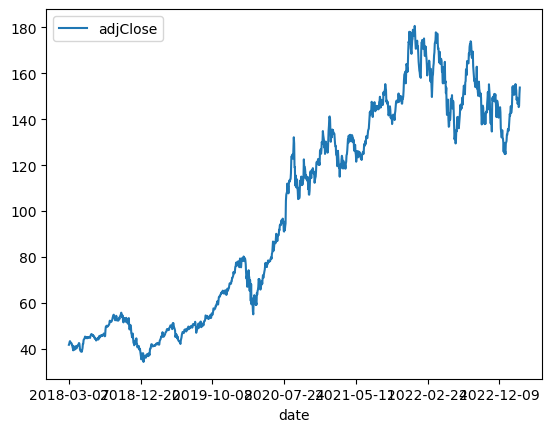

In [59]:
pd.DataFrame.from_records([x for i,x in enumerate(historical.find({'symbol':'AAPL'}))], index='date').sort_index()[['adjClose']].plot.line()